In [44]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import plotly.graph_objects as go
from tqdm.notebook import tqdm as tqdm
import seaborn as sns
import math
from datasets import Dataset
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.io import read_image
from PIL import Image
import torch
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim


sns.set_style('darkgrid')

In [9]:
# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print("Path to dataset files:", path)

Path to dataset files: /Users/macbookair/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [25]:
dataset_path = path
image_folder = os.path.join(dataset_path, "train")

In [50]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Путь к папке с данными (train или test).
            transform (callable, optional): Преобразования для изображений.
        """
        self.root_dirЁ = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, folder_name in enumerate(['REAL', 'FAKE']):
            folder_path = os.path.join(root_dir, folder_name)
            for image_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
        
transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

train_dataset = CustomImageDataset(root_dir=train_dir, transform=transform)
test_dataset = CustomImageDataset(root_dir=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

images, labels = next(iter(train_loader))
print(f"Images shape: {images.shape}")
print(f"Labels: {labels}")

Train dataset size: 100000
Test dataset size: 20000
Images shape: torch.Size([32, 3, 32, 32])
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1])


Провизуализируем происходящее

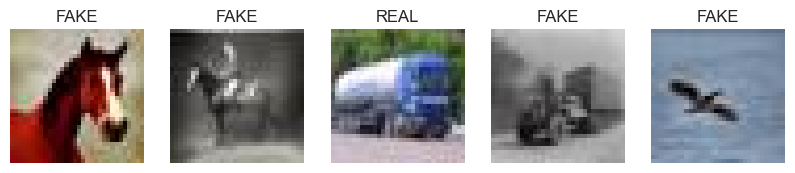

In [45]:
def show_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(10, 10))
    images = images[:num_images]
    labels = labels[:num_images]
    for i in range(len(images)):
        plt.subplot(1, num_images, i+1)
        img = images[i].permute(1, 2, 0)
        img = (img + 1) / 2
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

class_names = ['REAL', 'FAKE']
images, labels = next(iter(train_loader))
show_images(images, labels, class_names)

In [43]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.fc1 = nn.Linear(16*30*30, 2) 

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = x.view(-1, 16*30*30)
        x = self.fc1(x)
        return x

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5): 
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.291666716337204
Epoch 2, Loss: 0.324932336807251
Epoch 3, Loss: 0.562305748462677
Epoch 4, Loss: 0.20169128477573395
Epoch 5, Loss: 0.18846336007118225


Test Loss: 0.2589, Test Accuracy: 89.84%


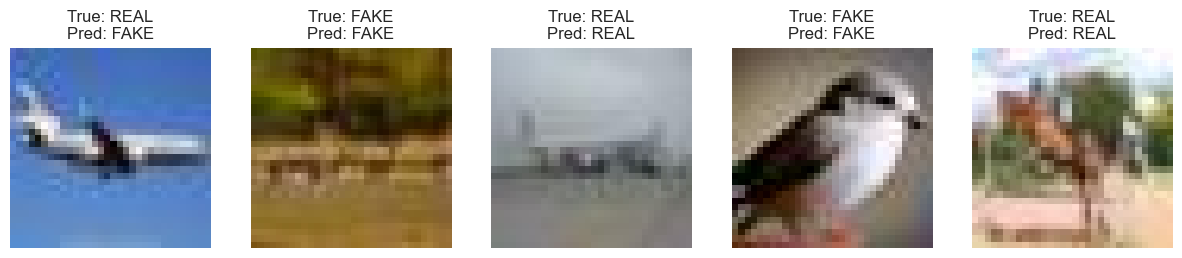

In [51]:
# Тестирование
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Визуализация
def show_images_with_predictions(images, labels, predictions, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    images = images[:num_images]
    labels = labels[:num_images]
    predictions = predictions[:num_images]
    for i in range(len(images)):
        plt.subplot(1, num_images, i+1)
        img = images[i].permute(1, 2, 0)
        img = (img + 1) / 2
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predictions[i]]}")
        plt.axis('off')
    plt.show()

images, labels = next(iter(test_loader))
outputs = model(images)
_, predictions = torch.max(outputs, 1)
class_names = ['REAL', 'FAKE']
show_images_with_predictions(images, labels, predictions, class_names)